In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fractions
# plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [2]:
def dim(l,m):
    return int((1/2)*(l+m)*(m+1)*(l+m+2))

def top_point(l,m):
    return np.array([l/2, (l+2*m)/3])

def expand_limits(ax, factor=1.2, factor_y=None):
    if factor_y is None:
        factor_y = factor
    ax.set_xlim(factor*np.array(ax.get_xlim()))
    ax.set_ylim(factor_y*np.array(ax.get_ylim()))
    
def rationalize_ticks(ax):
    ax.set_xticklabels([str(fractions.Fraction(t).limit_denominator(30)) for t in ax.get_xticks().tolist()])
    ax.set_yticklabels([str(fractions.Fraction(t).limit_denominator(30)) for t in ax.get_yticks().tolist()])
    
import matplotlib.text
def accommodate_text(ax):
    plt.draw()
    window_bbox = []
    for t in ax.get_children():
        if t.__class__ is matplotlib.text.Text:
            window_bbox.append(t.get_window_extent())
#     return window_bbox

    data_bbox   = [b.transformed(ax.transData.inverted()) for b in window_bbox]
    data_coords = np.array([b.extents for b in data_bbox])
    
    left, bottom = data_coords[:,:2].min(axis=0)
    right, top   = data_coords[:,2:].max(axis=0)

    left = min(left, ax.get_xlim()[0])
    right = max(right, ax.get_xlim()[1])
    bottom = min(bottom, ax.get_ylim()[0])
    top = max(top, ax.get_ylim()[1])
    
    ax.set_xlim(xmin=left, xmax=right)
    ax.set_ylim(ymin=bottom, ymax=top)
    
    expand_limits(ax, 1.1)

I = np.array([1,0])
U = np.array([-1/2,1])
V = np.array([-1/2,-1])

IT = np.array([0,1])
UT = np.array([1,1/2])
VT = np.array([1,-1/2])

UT = UT / np.linalg.norm(UT)
VT = VT / np.linalg.norm(VT)

def layer(l,m,n):
    multiplicity = 1
    for k in range(n-1):
        if l>0 and m>0:
            multiplicity += 1
            l += -1
            m += -1
        elif l == 0:
            m = m-3
        elif m == 0:
            l = l-3

    if l<0 or m<0:
        return None, None
    
    points = list()
    points.append(top_point(l,m))
    shifts = np.concatenate((
        np.ones(l)[:,np.newaxis]*(-I),
        np.ones(m)[:,np.newaxis]*(+V),
        np.ones(l)[:,np.newaxis]*(-U),
        np.ones(m)[:,np.newaxis]*(+I),
        np.ones(l)[:,np.newaxis]*(-V),
        np.ones(m)[:,np.newaxis]*(+U)
    ))
    for t in shifts:
        newpoint = points[-1] + t
        points.append(newpoint)
    
    return multiplicity, np.array(points).T

In [3]:
def draw_multiplet(ax, l, m, point_color='g', line_color='g', size=30,
                   no_frame=True, zero_lines=True, plot_title=True,
                   point_labels=False, point_label_disp=np.array([0,.1])):
    all_points = None
    for i in range(l+m):
        n, points = layer(l,m,i+1)

        if points is None:
            break

        if points.shape[1] > 1:
            scatter_points = points[:,:-1]
        else:
            scatter_points = points

        if all_points is None:
            all_points = scatter_points
        else:
            all_points = np.concatenate((all_points, scatter_points), axis=1)

        ax.plot(points[0], points[1], c=line_color, alpha=0.5, zorder=1)


    x_width = min(np.diff(ax.get_xlim())[0], np.diff(ax.get_ylim())[0])

    ax.scatter(all_points[0], all_points[1], s=4*size,
               edgecolors='w', facecolors='w', alpha=1, zorder=2)
    ax.scatter(all_points[0], all_points[1], s=size,
               edgecolors=point_color, facecolors=point_color, alpha=0.5, zorder=3)
    if point_labels:
        for point in all_points.T:
            px, py = [str(fractions.Fraction(p).limit_denominator(30)).split('/') for p in point]
            
            if len(px) > 1:
                if int(px[0]) < 0:
                    px = r"-\frac{" + px[0][1:] + r"}{" + px[1] + r"}"
                else:
                    px = r"\frac{" + px[0] + r"}{" + px[1] + r"}"
            else:
                px = px[0]
                
            if len(py) > 1:
                if int(py[0]) < 0:
                    py = r"-\frac{" + py[0][1:] + r"}{" + py[1] + r"}"
                else:
                    py = r"\frac{" + py[0] + r"}{" + py[1] + r"}"
            else:
                py = py[0]
                
            txt = r"$\left("+px+r',~'+py+r"\right)$"
            ax_txt = ax.text(*(point+point_label_disp), txt, ha='center')
            ax_txt.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='gray'))

    if zero_lines:
        ax.axhline(0, c='gray', alpha=0.25, linestyle='solid', zorder=2)
        ax.axvline(0, c='gray', alpha=0.25, linestyle='solid', zorder=2)
    
    ax.set_xlabel(r'Isospin $I_3$')
    ax.set_ylabel(r'Hypercharge $Y$')
    
    if plot_title:
        ax.set_title(r'$\lambda=' + str(l) + r',\mu=' + str(m) + r'$')

    ax.set_aspect(1)
    if no_frame:
        ax.axis('off')

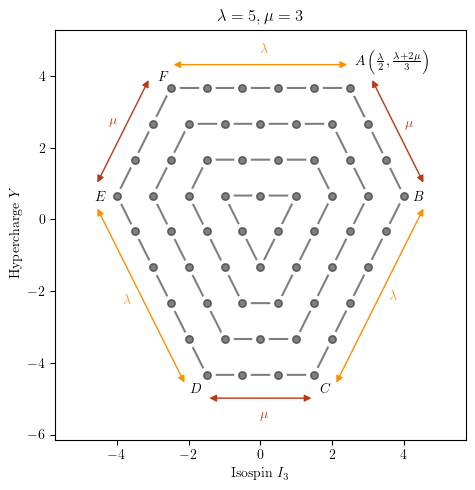

In [4]:
fig0, ax0 = plt.subplots(figsize=(5,5))

lamb = 5
mu   = 3

lamb_c = "#FB9300"
mu_c   = "#BB371A"

pd = 0.65

draw_multiplet(ax0, lamb, mu,
               size=30,
               point_color='k', line_color='k', no_frame=False, zero_lines=False)

A = top_point(lamb, mu)
B = A-mu*U
C = B+lamb*V
D = C-mu*I
E = D+lamb*U
F = E-mu*V

# ax.text(*(A+padding), r"$A\left(\frac{\lambda}{2},\frac{\lambda+2\mu}{3}\right)$")

ax0.annotate(text=r"$A\left(\frac{\lambda}{2},\frac{\lambda+2\mu}{3}\right)$", xy=A, xytext=A+[.15, .6])
ax0.annotate(text=r"$B$", xy=B, xytext=B+[.25,-.15])
ax0.annotate(text=r"$C$", xy=C, xytext=C+[.15,-.5])
ax0.annotate(text=r"$D$", xy=D, xytext=D+[-.45,-.5])
ax0.annotate(text=r"$E$", xy=E, xytext=E+[-.60,-.15])
ax0.annotate(text=r"$F$", xy=F, xytext=F+[-.35,.2])

ax0.annotate(text='', xy=A+pd*UT, xytext=B+pd*UT, arrowprops=dict(arrowstyle='<|-|>', color=mu_c))
ax0.annotate(text='', xy=B+pd*VT, xytext=C+pd*VT, arrowprops=dict(arrowstyle='<|-|>', color=lamb_c))
ax0.annotate(text='', xy=C-pd*IT, xytext=D-pd*IT, arrowprops=dict(arrowstyle='<|-|>', color=mu_c))
ax0.annotate(text='', xy=D-pd*UT, xytext=E-pd*UT, arrowprops=dict(arrowstyle='<|-|>', color=lamb_c))
ax0.annotate(text='', xy=E-pd*VT, xytext=F-pd*VT, arrowprops=dict(arrowstyle='<|-|>', color=mu_c))
ax0.annotate(text='', xy=F+pd*IT, xytext=A+pd*IT, arrowprops=dict(arrowstyle='<|-|>', color=lamb_c))

ax0.text(*((A+B)/2+1.35*pd*UT), r'$\mu$', color=mu_c)
ax0.text(*((B+C)/2+1.45*pd*VT), r'$\lambda$', color=lamb_c)
ax0.text(*((C+D)/2-1.85*pd*IT), r'$\mu$', color=mu_c)
ax0.text(*((D+E)/2-1.85*pd*UT), r'$\lambda$', color=lamb_c)
ax0.text(*((E+F)/2-1.65*pd*VT), r'$\mu$', color=mu_c)
ax0.text(*((F+A)/2+1.50*pd*IT), r'$\lambda$', color=lamb_c)

expand_limits(ax0, 1.3)

plt.tight_layout()
plt.show()

In [5]:
fig0.savefig("fig_multiplet_building.pdf")

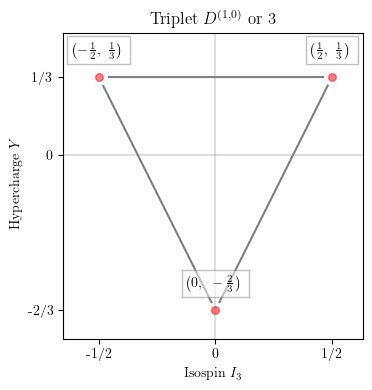

In [6]:
fig1, ax1 = plt.subplots()

draw_multiplet(ax1, 1, 0,
               size=30,
               point_color='r', line_color='k',
               no_frame=False, plot_title=False,
               zero_lines=True, point_labels=True,
               point_label_disp=np.array([0,.1]))

ax1.set_title(r"Triplet $D^{(1,0)}$ or 3")
accommodate_text(ax1)

ax1.set_xticks([-1/2, 0, 1/2])
ax1.set_yticks([-2/3, 0, 1/3])
rationalize_ticks(ax1)

plt.tight_layout()
plt.show()

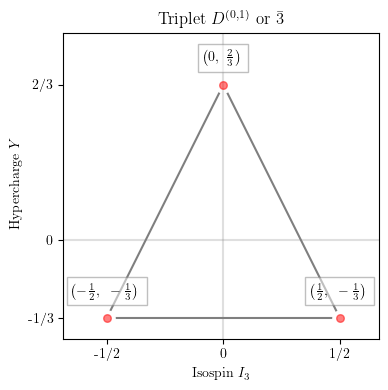

In [7]:
fig2, ax2 = plt.subplots()

draw_multiplet(ax2, 0, 1,
               size=30,
               point_color='r', line_color='k',
               no_frame=False, plot_title=False,
               zero_lines=True, point_labels=True,
               point_label_disp=np.array([0,.1]))

ax2.set_title(r"Triplet $D^{(0,1)}$ or $\bar{3}$")
accommodate_text(ax2)

ax2.set_xticks([-1/2, 0, 1/2])
ax2.set_yticks([-1/3, 0, 2/3])
rationalize_ticks(ax2)

plt.tight_layout()
plt.show()

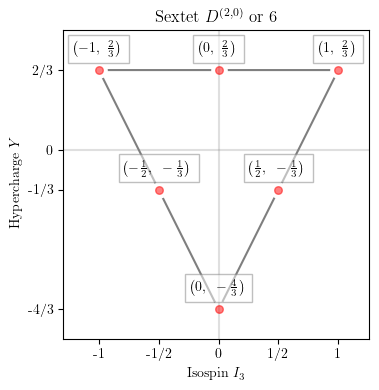

In [8]:
fig3, ax3 = plt.subplots()

draw_multiplet(ax3, 2, 0,
               size=30,
               point_color='r', line_color='k',
               no_frame=False, plot_title=False,
               zero_lines=True, point_labels=True,
               point_label_disp=np.array([0,.15]))

ax3.set_title(r"Sextet $D^{(2,0)}$ or 6")
accommodate_text(ax3)

ax3.set_xticks([-1, -1/2, 0, 1/2, 1])
ax3.set_yticks([-4/3, -1/3, 0, 2/3])
rationalize_ticks(ax3)

plt.tight_layout()
plt.show()

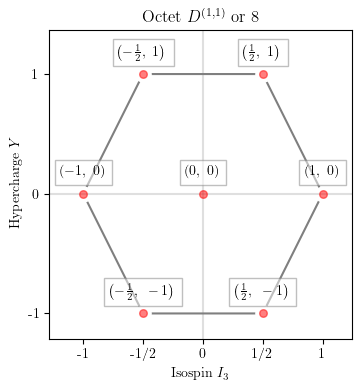

In [9]:
fig4, ax4 = plt.subplots()

draw_multiplet(ax4, 1, 1,
               size=30,
               point_color='r', line_color='k',
               no_frame=False, plot_title=False,
               zero_lines=True, point_labels=True,
               point_label_disp=np.array([0,.15]))

ax4.set_title(r"Octet $D^{(1,1)}$ or 8")
accommodate_text(ax4)

ax4.set_xticks([-1, -1/2, 0, 1/2, 1])
ax4.set_yticks([-1, 0, 1])
rationalize_ticks(ax4)

plt.tight_layout()
plt.show()

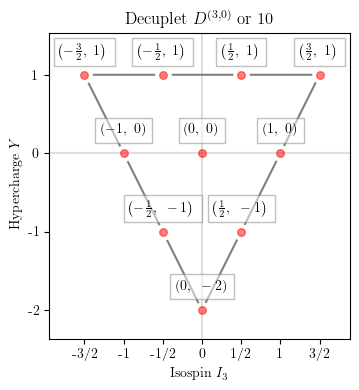

In [10]:
fig5, ax5 = plt.subplots()

draw_multiplet(ax5, 3, 0,
               size=30,
               point_color='r', line_color='k',
               no_frame=False, plot_title=False,
               zero_lines=True, point_labels=True,
               point_label_disp=np.array([0,.25]))

ax5.set_title(r"Decuplet $D^{(3,0)}$ or 10")
accommodate_text(ax5)

ax5.set_xticks([-3/2, -1, -1/2, 0, 1/2, 1, 3/2])
ax5.set_yticks([-2, -1, 0, 1])
rationalize_ticks(ax5)

plt.tight_layout()
plt.show()

In [11]:
fig1.savefig("fig_multiplet_triplet.pdf")
fig2.savefig("fig_multiplet_anti-triplet.pdf")
fig3.savefig("fig_multiplet_sextet.pdf")
fig4.savefig("fig_multiplet_octet.pdf")
fig5.savefig("fig_multiplet_decuplet.pdf")

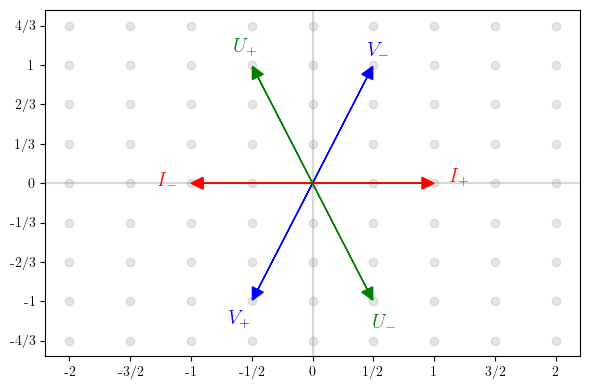

In [12]:
figbas, axbas = plt.subplots()

x_ticks = np.arange(-4, 5) / 2
y_ticks = np.arange(-4, 5) / 3
x_tick_labels = [str(fractions.Fraction(p).limit_denominator(30)) for p in x_ticks]
y_tick_labels = [str(fractions.Fraction(p).limit_denominator(30)) for p in y_ticks]

gridpoints = []
for i in x_ticks:
    for j in y_ticks:
        gridpoints.append([i, j])
        
gridpoints = np.array(gridpoints, dtype=float).T

axbas.scatter(gridpoints[0], gridpoints[1], c='gray', alpha=0.2, zorder=1)
axbas.axhline(0, c='gray', alpha=0.3, zorder=0)
axbas.axvline(0, c='gray', alpha=0.3, zorder=0)

axbas.set_xticks(x_ticks)
axbas.set_yticks(y_ticks)

axbas.set_xticklabels(x_tick_labels)
axbas.set_yticklabels(y_tick_labels)

axbas.arrow(0, 0, *(I*0.9), head_width=0.1, head_length=0.1, fc='r', ec='r')
axbas.arrow(0, 0, *(-I*0.9), head_width=0.1, head_length=0.1, fc='r', ec='r')

axbas.arrow(0, 0, *(V*0.9), head_width=0.1, head_length=0.1, fc='b', ec='b')
axbas.arrow(0, 0, *(-V*0.9), head_width=0.1, head_length=0.1, fc='b', ec='b')

axbas.arrow(0, 0, *(U*0.9), head_width=0.1, head_length=0.1, fc='g', ec='g')
axbas.arrow(0, 0, *(-U*0.9), head_width=0.1, head_length=0.1, fc='g', ec='g')

axbas.text(*I*1.2, r"$I_+$", ha='center', c='r', fontsize='x-large')
axbas.text(*-I*1.2, r"$I_-$", ha='center', c='r', fontsize='x-large')

axbas.text(*V*1.2, r"$V_+$", ha='center', c='b', fontsize='x-large')
axbas.text(*-V*1.1, r"$V_-$", ha='center', c='b', fontsize='x-large')

axbas.text(*U*1.1, r"$U_+$", ha='center', c='g', fontsize='x-large')
axbas.text(*-U*1.2, r"$U_-$", ha='center', c='g', fontsize='x-large')

plt.tight_layout()
plt.show()

In [13]:
figbas.savefig("fig_su3_basis.pdf")

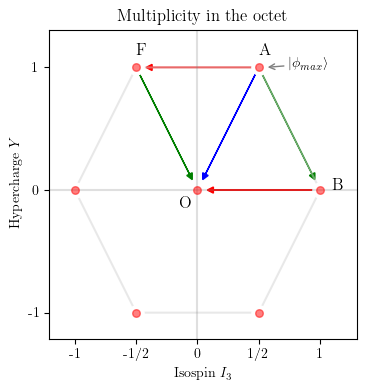

In [14]:
figoctet, axoctet = plt.subplots()

draw_multiplet(axoctet, 1, 1,
               size=30,
               point_color='r', line_color='#D3D3D3',
               no_frame=False, plot_title=False,
               zero_lines=True, point_labels=False,
               point_label_disp=np.array([0,.15]))

axoctet.text(0.5, 1.1, "A", fontsize='large')
axoctet.text(1.1, 0.0, "B", fontsize='large')
axoctet.text(-0.5, 1.1, "F", fontsize='large')
axoctet.text(-.05, -.15, "O", fontsize='large', ha='right')

axoctet.annotate(text=r"$|\phi_{max}\rangle$", xy=(0.55, 1.0), xytext=(.75, 1.0), arrowprops=dict(arrowstyle='->', color='gray'))

axoctet.arrow(0.5, 1.0, *V*0.87, head_width=0.05, head_length=0.05, fc='b', ec='b')

axoctet.arrow(0.5, 1.0, *-I*0.87, head_width=0.05, head_length=0.05, fc='r', ec='r')
axoctet.arrow(-0.5, 1.0, *-U*0.87, head_width=0.05, head_length=0.05, fc='g', ec='g')

axoctet.arrow(0.5, 1.0, *-U*0.87, head_width=0.05, head_length=0.05, fc='g', ec='g')
axoctet.arrow(1.0, 0.0, *-I*0.87, head_width=0.05, head_length=0.05, fc='r', ec='r')

accommodate_text(axoctet)

axoctet.set_xticks([-1, -1/2, 0, 1/2, 1])
axoctet.set_yticks([-1, 0, 1])
rationalize_ticks(axoctet)

axoctet.set_title(r"Multiplicity in the octet")

plt.tight_layout()
plt.show()

In [15]:
figoctet.savefig("fig_octet_multiplicity.pdf")

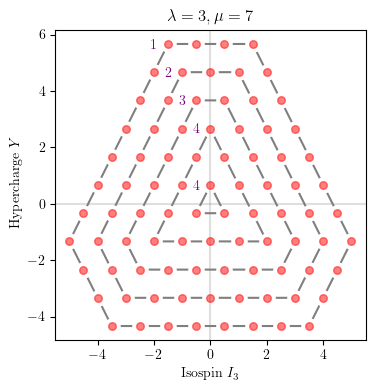

In [16]:
figmult, axmult = plt.subplots()

draw_multiplet(axmult, 3, 7,
               size=30,
               point_color='r', line_color='k',
               no_frame=False, plot_title=True,
               zero_lines=True)

axmult.text(-2, 5.5, "1", ha='center', c='purple')
axmult.text(-1.5, 4.5, "2", ha='center', c='purple')
axmult.text(-1, 3.5, "3", ha='center', c='purple')
axmult.text(-0.5, 2.5, "4", ha='center', c='purple')
axmult.text(-0.5, 0.5, "4", ha='center', c='purple')

plt.tight_layout()
plt.show()

In [17]:
figmult.savefig("fig_multiplicity.pdf")